> Created on Fri Oct 13 09:47:20 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 4.10 图神经网络 （Graph Neural Networks，GNN）

## 4.10.1 图嵌入（graph embedding）

图（复杂网络）是一种用于描述和建模复杂系统（complex systems）的通用语言。通过量化的图分析可以更好的理解复杂网络，但是对于包含大量顶点和边及其属性的网络而言，通常需要使用图嵌入技术有效的将高维稀疏图转换为低维、密集和连续的（嵌入）向量空间，最大限度的保留图的结构属性，从而很容易在嵌入向量空间中使用标准度量量化原始复杂不规则空间中顶点的相似度<sup>[Xu, M. (2021). Understanding Graph Embedding Methods and Their Applications. SIAM Review, 63(4), 825–853. doi:10.1137/20M1386062][Abdel-Basset, M., Moustafa, N., Hawash, H., & Tari, Z. (2023). Responsible Graph Neural Networks (1st ed.). Chapman and Hall/CRC. https://doi.org/10.1201/9781003329701]57</sup>。图嵌入的方法有 DeepWalk<sup>[Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online Learning of Social Representations. In Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 701–710). Association for Computing Machinery.]</sup>、node2vec<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>、Line<sup>[Tang, J., Qu, M., Wang, M., Zhang, M., Yan, J. & Mei, Q. (2015). LINE: Large-scale Information Network Embedding. WWW (p./pp. 1067--1077), New York, NY, USA: ACM. ISBN: 978-1-4503-3469-3]</sup>、SDNE<sup>[Shen, X. & Chung, F.-L. (2019). Deep Network Embedding for Graph Representation Learning in Signed Networks.. CoRR, abs/1901.01718.]</sup>和 struc2vec<sup>[Ribeiro, L. F., Saverese, P. H. & Figueiredo, D. R. (2017). struc2vec: Learning Node Representations from Structural Identity. Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD '17 (p./pp. 385--394), Halifax, NS, Canada: ACM Press. ISBN: 978-1-4503-4887-4]</sup>等。


### 4.10.1.1 DeepWalk

Perozzi, B.等人<sup>[Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online Learning of Social Representations. In Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 701–710). Association for Computing Machinery.]</sup>基于自然语言处理中词嵌入的 Word2Vec<sup>[ Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1301.3781]</sup> 方法（可以查看*Transformer——自然语言处理*部分）提出了处理复杂网络的 DeepWalk， 该方法以一个图作为输入，通过给定深度（长度、次数）随机漫步（Random Walks）获得每个顶点随机邻接顶点，及随机邻接顶点的随机邻接顶点不断迭代深度的一个行走序列顶点列表来获取每个顶点的局部信息，将其视为自然语言处理中的语料库（corpus）用于学习复杂网络顶点（词）的嵌入向量/潜在表征（latent representations ）。

#### 1） 随机漫步（Random Walks）

以顶点$v_i$为源，其随机漫步的顶点（属性）列表记为$\mathcal{W}_{v_i}$，为一个随机过程，包含给定长度的随机变量 $ \mathcal{W}_{v_i}^1, \mathcal{W}_{v_i}^2, \ldots, \mathcal{W}_{v_i}^k$。对于一个随机变量$\mathcal{W}_{v_i}^{k+1}$，是从顶点$v_k$邻接顶点中随机选择的一个顶点。随机漫步已被用于内容推荐（content recommendation）、社区检测（community detection）等各类问题中的相似性度量。除了作为可以从网络中提取信息的基本工具，随机漫步能够执行并行计算，即可以同时探索一个图中的不同部分信息，提高计算效率；其次，依赖从随机漫步中获得的信息，可以在不需要全局重新计算的情况下适应图结构的微小变化，用新的随机漫步迭代更新已学习到的模型。

定义`RandomWalker`类，其`deepwalk_walk`方法<sup>[GraphEmbedding, <https://github.com/shenweichen/GraphEmbedding>]</sup>实现了网络顶点随机漫步的算法，代码如下，

```python
def deepwalk_walk(self, walk_length, start_node):
    walk = [start_node]

    while len(walk) < walk_length:
        cur = walk[-1]
        cur_nbrs = list(self.G.neighbors(cur))
        if len(cur_nbrs) > 0:
            walk.append(random.choice(cur_nbrs))
        else:
            break
    return walk
```

计算以[NetworkX](https://networkx.org/documentation/stable/index.html)库提供的`erdos_renyi_graph`<sup>[P.Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).]</sup>随机图中顶点`0`的随机漫步为例，计算结果如下。

In [1]:
%load_ext autoreload 
%autoreload 2
import usda.network as usda_network 
import usda.network.graph_embedding as usda_ge
import usda.manifold as usda_manifold

import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

C:\Users\richie\anaconda3\envs\rl\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


`erdos_renyi_graph(n, p, seed=None, directed=False)`方法中，参数`n`为顶点的数量；`p`为创建边的概率。

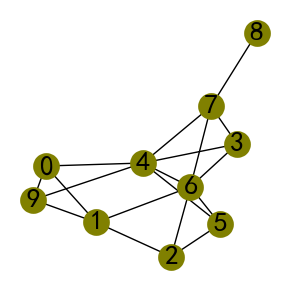

In [13]:
G_er=nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
usda_network.G_drawing(G_er)

仅计算了图中顶点0的随机漫步，随机选择了其邻接顶点4；而顶点4的随机邻接顶点为7，顶点7的随机邻接顶点为6，以此类推，完成指定长度的随机漫步。

In [17]:
G_er_randomwalk=usda_ge.RandomWalker(G_er)
walk_lst=G_er_randomwalk.deepwalk_walk(walk_length=10, start_node=0)
walk_lst

[0, 4, 7, 6, 4, 5, 4, 5, 4, 3]

#### 2）从自然语言处理的词嵌入到复杂网络的图（顶点）嵌入         

自然语言建模的目的是估计语料库中更容易构成具有意义短语或句子词汇组合的可能性。给出一个词汇组成的序列（句子或短语）$W_1^n=\left(w_0, w_1, \cdots, w_n\right)$，式中， $w_i \in \mathcal{V}$（$ \mathcal{V}$是词汇表），希望对于所有训练的语料库最大化$\operatorname{Pr}\left(w_n \mid w_0, w_1, \cdots, w_{n-1}\right)$。对应到复杂网络，将词汇对应到顶点，将词汇组成的句子对应到随机漫步表征局部网络结构特征的顶点序列上，则观测到顶点$v_i$的可能性的公式可表示为$\operatorname{Pr}\left(v_i \mid\left(v_1, v_2, \cdots, v_{i-1}\right)\right)$。

顶点嵌入向量的估计同词嵌入是要学习到可以表征网络结构顶点间的距离关系，而不仅仅是顶点共现（co-occurrences）的概率分布。因此引入一个映射函数$\Phi: v \in V \mapsto \mathbb{R}^{|V| \times d} $，式中，$\Phi$表示与图中每个顶点$v$相关的嵌入向量空间，并用一个$|V| \times d$大小的矩阵表示，有$\operatorname{Pr}\left(v_i \mid\left(\Phi\left(v_1\right), \Phi\left(v_2\right), \cdots, \Phi\left(v_{i-1}\right)\right)\right)$。在 Word2Vec 中，上述方法称之为 CBOW（Continuous Bag-of-Words），而提出的 Skip-gram 结构模型表现要好于 CBOW，其不是使用上下文语境来预测缺失的词，与其相反，由该词预测上下文中出现词的概率，对应到复杂网络，上述公式调整为$\underset{\Phi}{\operatorname{minimize}} \quad-\log \operatorname{Pr}\left(\left\{v_{i-w}, \cdots, v_{i-1}, v_{i+1}, \cdots, v_{i+w}\right\} \mid \Phi\left(v_i\right)\right)$。给定顶点$v_i$，最大化其邻接顶点在随机漫步中的概率，可以用分类器（如逻辑回归 SoftMax函数）来学习这种后验分布。然而，使用逻辑回归建模将会产生大量（数量等于$\mid V \mid$）的标签，为了加快训练速度，可以使用  Hierarchical Softmax（H-Softmax） 方法近似概率分布。

* 霍夫曼编码（Huffman Coding）

在计算机科学和信息理论中，David A. Huffman <sup>[Huffman, D. (1952). A Method for the Construction of Minimum-Redundancy Codes. Proceedings of the IRE, 40(9), 1098–1101. doi:10.1109/jrproc.1952.273898 ]</sup>提出了一种特殊类型的最优前缀码（prefix code），称为霍夫曼编码（Huffman Coding），通常用于无损数据压缩。在下述的试验中，提供了一组字符`data`，包括有`['a',  'b', 'c', 'd', 'e']`等5个字符，假设每个字符在语料库中出现的频率`freq`，为`[0.10, 0.15, 0.30,0.16, 0.29]`，和为1，那么对其进行霍夫曼编码结果如下图。从图中可以观察到霍夫曼编码的过程，将字母按照其权值排序，首先选择最小权值的两个字母`a`和`b`，构造其父顶点，权值为`a`和`b`之和 0.25；继续排序剩余的顶点加上新构造的父顶点，仍旧选择最小权值的两个顶点，`d`和新构造值为0.25的顶点构造其父顶点，以其和为父顶点的权值，即 0.41，以此类推，直至完成所有顶点的图构造，并最终存在一个根顶点。因为字符的频率和为1，因此根顶点的权值为1。而每个字符均位于叶顶点（节点）。且总共增加的新顶点数为$5-1=4$。

如果将每个顶点的左分支标记为0，而右分支标记为1，则可以编码叶顶点，例如对于字符`a`，其霍夫曼编码结果为`010`；对于字符`c`，其霍夫曼编码结果为`11`。从编码结果可以发现，字符出现的频率高，则其编码长度会相对短；而字符出现的频率低，则其编码的长度相对长。如果使用二进制定长编码（给每个字符一个固定长度的编码），对于试验中的5个字符，需要至少长度为3个位数（$3^2-1=8$）满足要求，那么总共位数为 15。而霍夫曼编码结果总位数为12，这要小于定长编码，因此可以有效的压缩数据。

{'d': [0, 0], 'a': [0, 1, 0], 'b': [0, 1, 1], 'e': [1, 0], 'c': [1, 1]}


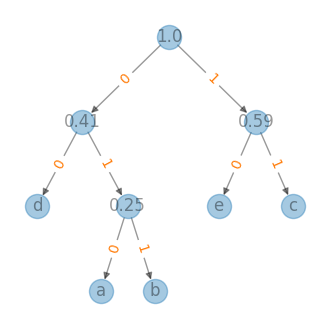

In [10]:
data=['a',  'b', 'c', 'd', 'e']
freq=[0.10, 0.15, 0.30,0.16, 0.29]
size=len(data)

root=usda_network.HuffmanCodes(data, freq, size,verbose=False)
usda_network.draw_tree(root,figsize=(4,4))

huffman_encoding_dict=usda_network.huffman_encoding_dict
print(huffman_encoding_dict)

定义`huffman_encode()`和`huffman_decode()`方法，根据上述构造的霍夫曼编码树`root`，实现对任意给定字符组合的霍夫曼编码和解码。

In [11]:
s='badbed'
s_encoded=usda_network.huffman_encode(s,huffman_encoding_dict)
print(s_encoded)
s_decoded=usda_network.huffman_decode(s_encoded,root)
print(s_decoded)

011010000111000
badbed


* Hierarchical Softmax（H-Softmax）<sup>[Rong, X. (2014). word2vec parameter learning explained. arXiv preprint arXiv:1411.2738.]</sup>

H-Softmax 是一种计算 softmax 的有效方法<sup>[[Morin, F., & Bengio, Y. (2005). Hierarchical Probabilistic Neural Network Language Model. In Proceedings of the Tenth International Workshop on Artificial Intelligence and Statistics (pp. 246–252). PMLR.]]</sup>，使用霍夫曼编码树编码词汇表中所有的词汇，如图<sup>[Rong, X. (2014). word2vec parameter learning explained. arXiv preprint arXiv:1411.2738.]</sup>，其中白色圆圈为叶顶点，对应到各个词汇；黑色圆圈为内部（中间）顶点。每个词汇均有一个从根（root）到对应叶顶点的唯一路径，该路径用于估计由叶顶点表示的词汇的概率。例如对于词汇`w_2`，用顶点路径表示的编码长度为$L\left(w_2\right)=4$。$n(w, j)$表示路径中第$j $个顶点。

<img src="../imgs/4_10_4/4_10_4_01.png" height='auto' width='300' title="caDesign"> 

在 H-Softmax 中，一个词汇的概率定义为，$p\left(w=w_O\right)=\prod_{j=1}^{L(w)-1} \sigma\left([\![ n(w, j+1)=\operatorname{ch}(n(w, j)) ]\!] \cdot \mathbf{v}_{n(w, j)}^{\prime}{ }^T \mathbf{h}\right)$，式中，$ch(n)$为顶点$n$的左分支子顶点；$\mathbf{v}_{n(w, j)}^{\prime}$为内部顶点$n(w, j)$的嵌入向量/向量表示（vector representation）；$\mathbf{h}$是隐藏层的输出值，在 Skip-gram 模型中，$\mathbf{h}=\mathbf{v}_{w_I}$，为词汇$w$的嵌入向量<sup>[Mikolov, T., Sutskever, I., Chen, K., Corrado, G., & Dean, J. (2013). Distributed Representations of Words and Phrases and their Compositionality. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1310.4546]</sup>。在 CBOW 模型中，$\mathbf{h}=\frac{1}{C} \sum_{c=1}^C \mathbf{v}_{w_c}$。因此在 H-Softmax 中，并没有输出词嵌入矩阵，而是为词内部顶点的嵌入向量$\mathbf{v}_{n(w, j)}^{\prime}$；$[\![x]\!]$为一个特殊函数，定义为，$[\![ x ]\!]= \begin{cases}1 & \text { if } x \text { is true; } \\ -1 & \text { otherwise }\end{cases}$。

计算上图中$w_2$作为输出词的概率，该概率定义为从根顶点开始随机漫步，结束于该词对应的叶顶点。对于每个内部顶点（包括根顶点），需要分配向左或向右的概率。如果定义内部顶点$n$向左的概率为$p(n, \text { left })=\sigma\left(\mathbf{v}_n^{\prime T} \cdot \mathbf{h}\right)$，由内部顶点的嵌入向量和该词的嵌入向量确定；因此，内部顶点$n$向右的概率为，$p(n, \text { right })=  1-\sigma\left(\mathbf{v}_n^{\prime T} \cdot \mathbf{h}\right)=\sigma\left(-\mathbf{v}_n^{\prime T} \cdot \mathbf{h}\right) $。因此按照上图给出的词$w_2$的路径，计算$w_2$作为输出词的概率为，$p\left(w_2=w_O\right)  =p\left(n\left(w_2, 1\right), \text { left }\right) \cdot p\left(n\left(w_2, 2\right), \text { left }\right) \cdot p\left(n\left(w_2, 3\right), \text { right }\right) \\ =\sigma\left(\mathbf{v}_{n\left(w_2, 1\right)}^{\prime}{ }^T \mathbf{h}\right) \cdot \sigma\left(\mathbf{v}_{n\left(w_2, 2\right)}^{\prime}{ }^T \mathbf{h}\right) \cdot \sigma\left(-\mathbf{v}_{n\left(w_2, 3\right)}^{\prime}{ }^T \mathbf{h}\right)$，并且，$\sum_{i=1}^V p\left(w_i=w_O\right)=1$。

回到复杂网络，将顶点构造为霍夫曼编码树，对于顶点$u_k \in V$，计算$\operatorname{Pr}\left(u_k \mid \Phi\left(v_j\right)\right)$可以转化为最大化树中特定路径的概率。如果到顶点$u_k$的路径表示为一个树顶点的序列$\left(b_0, b_1, \ldots, b_{\lceil\log |V|\rceil}\right), \quad\left(b_0=\right. root,\left.b_{\lceil\log |V|\rceil}=u_k\right)$，则，$\operatorname{Pr}\left(u_k \mid \Phi\left(v_j\right)\right)=\prod_{l=1}^{\lceil\log |V|\rceil} \operatorname{Pr}\left(b_l \mid \Phi\left(v_j\right)\right)$，式中，$\operatorname{Pr}\left(b_l \mid \Phi\left(v_j\right)\right)$可以通过顶点$b_l$父顶点的二元分类器建模，从而降低了计算$\operatorname{Pr}\left(u_k \mid \Phi\left(v_j\right)\right)$的复杂度， 从$O(\mid V \mid)$降低到$O(\log \mid V \mid)$。

#### 3）空手道俱乐部的 DeepWalk 图嵌入

下述的试验以`NetworkX`库提供的`karate_club_graph`图<sup>[Zachary, Wayne W. “An Information Flow Model for Conflict and Fission in Small Groups.” Journal of Anthropological Research, 33, 452–473, (1977).]</sup>为例计算图嵌入。该图总共有34个顶点，顶点有字段为`club`的属性，表示该节点是属于`Mr. Hi`还是`Officer`阵营。每个边赋予了一个权值，为基于该边相互作用顶点在上下文语境中出现的次数。

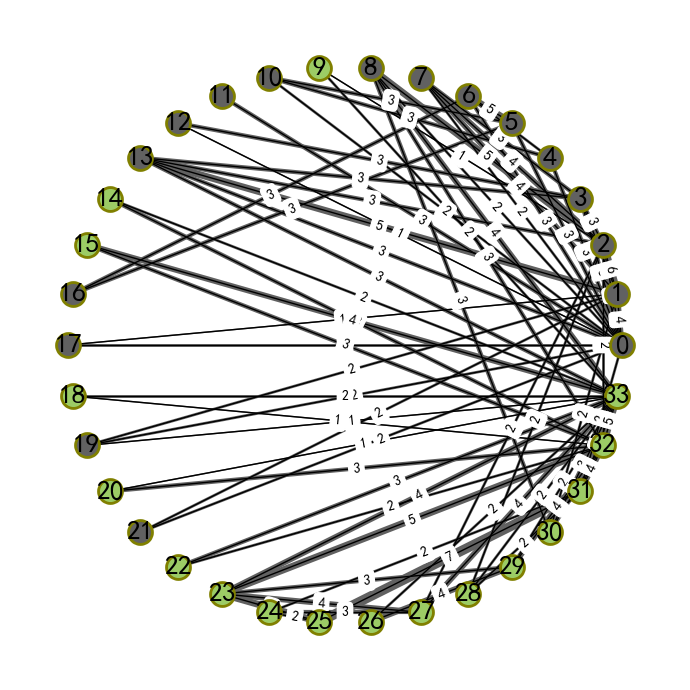

In [9]:
G_karate_club=nx.karate_club_graph()
pos=nx.circular_layout(G_karate_club)

nodes_attri=pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in dict(G_karate_club.nodes(data=True)).items()}, axis=0).reset_index().rename(columns={'level_0':'node','level_1':'attri',0:'club'})
nodes_attri_groups=nodes_attri.groupby("club")["node"].apply(list).reset_index()

edge_attributes=nx.get_edge_attributes(G_karate_club,'weight')
usda_network.G_drawing(G_karate_club,
                       nodes=nodes_attri_groups.node.tolist(),
                       nodes_color=['#616161','#9CCC65'],
                       pos=pos,figsize=(7,7),
                       routes=list(edge_attributes.keys()),
                       edge_widths=list(edge_attributes.values()),
                       edge_labels='weight',
                       edge_colors=['#616161']*len(edge_attributes))

查看图的顶点和边属性。

In [10]:
print(list(G_karate_club.nodes(data=True))[17:21])
print(list(G_karate_club.edges(data=True))[:3])

[(17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'})]
[(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3})]


将顶点属性编码为整数值。

In [11]:
nodes_attri['club_int']=nodes_attri.club.apply(lambda x:1 if x=='Officer' else 0)
nodes_attri[8:11]

,node,attri,club,club_int
8,8,club,Mr. Hi,0
9,9,club,Officer,1
10,10,club,Mr. Hi,0


定义`DeepWalk`类实现 DeepWalk 图嵌入算法，核心使用`gensim`库的`Word2Vec`方法。配置嵌入向量的维度`embed_size`(`vector_size`)为 128 维；使用 Skip-gram 模型（`sg=1`）和 H-Softmax 算法（`hs=1`）；配置当前顶点到预测顶点间的最大距离`window_size`（`window`）为10；并执行并行计算（`workers=3`）。

In [150]:
model_deepwalk=usda_ge.DeepWalk(G_karate_club, walk_length=10, num_walks=80, workers=1)
model_deepwalk.train(
    window_size=10, 
    iter=30,
    sg=1, # Skip-gram
    hs=1, # Hierarchical softmax
    workers=3,
    embed_size=128,
    );

Learning embedding vectors...
Learning embedding vectors done!


查看计算结果，获得顶点的嵌入矩阵，维度为`(顶点数，嵌入向量维数)`。

In [167]:
embeddings=model_deepwalk.get_embeddings()
embeddings_array=np.array([embeddings[node] for node in G_karate_club.nodes])
embeddings_array.shape

(34, 128)

使用`wv.most_similar`方法可以计算与给定顶点距离最近的多个顶点（由近及远排序）。对于顶点 0，基于上述图结构，与其最近的顶点为 4，距离值约为 0.746（距离度量使用 cosine similarity 算法）。

In [158]:
model_deepwalk.w2v_model.wv.most_similar(positive=[0])

[(4, 0.7461870312690735),
 (10, 0.690133273601532),
 (3, 0.6589341759681702),
 (6, 0.6216689348220825),
 (5, 0.6070966124534607),
 (12, 0.5991224050521851),
 (16, 0.5978891849517822),
 (1, 0.5969511866569519),
 (11, 0.5932941436767578),
 (21, 0.5916509628295898)]

可以直接使用`wv.similarity`方法计算给定两个顶点间的距离。

In [159]:
model_deepwalk.w2v_model.wv.similarity(0,4)

0.74618703

使用 t-SNE 算法降维图顶点嵌入矩阵，由 128 维降至 2 维打印查看顶点的分布情况。从结果来看，代表不同阵营的顶点能够很好的分离，表明了 DeepWalk 图嵌入方法可以将图顶点转化为连续的嵌入向量空间，分析图结构。

In [217]:
Y=usda_manifold.tsne(embeddings_array,2,max_iter=1000,print_interval=200,init='pca',random_state=0,learning_rate='auto')

Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 2.0342620 of 34...


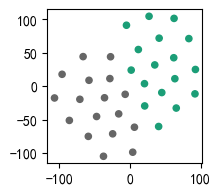

In [218]:
plt.figure(figsize=(2, 2), dpi=100)
plt.scatter(Y[:, 0], Y[:, 1], 20, nodes_attri.club_int,cmap='Dark2')
plt.show()

### 4.10.1.2 node2vec<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>

#### 1）BFS 和 DFS 

下图<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>呈现了网络结构的两个特性，第一种特征是同质性（homophily），如顶点$U$和顶点$S_1,S_2,S_3$之间的关系，这几个顶点属于同一个紧密结合的社区，顶点之间边的数量（路的长度）趋小，而之间边的权值趋大；另一种特征是结构等效性（structural equivalence），如顶点$U$和$S_6$，这两个顶点并不是紧密相连，而是位于不同的社区中，但是表现出相似的结构特征，为各自所在社区中心顶点的角色，其顶点度均为4，与邻接顶点构成围长为3的圈有3~4个。

为了权衡同质性和结构等效性，Grover, A.<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>等人将源顶点邻域采样问题看作是一种局部搜索形式，提出了两种采样策略，广度优先采样（ Breadth-ﬁrst Sampling，BFS）和深度优先采样（Depth-ﬁrst Sampling，DFS）。BFS 倾向于采样源顶点邻域邻接的顶点，如$U$邻接顶点$S_1,S_2,S_3$；DFS 倾向于由距离源顶点越来愈远的顶点依次采样组成，如$U$与$S_4,S_5,S_6$。

<img src="../imgs/4_10_4/4_10_4_02.png" height='auto' width='300' title="caDesign"> 

BFS 和 DFS 代表了同质性和结构等效性两种极端搜索的情境，并对学习到的图嵌入向量空间产生影响。而复杂网络的顶点预测任务经常在同质性和结构等效性之间变换。在同质性假设下，高度互连和属于相似簇或社区的顶点，对其估计的嵌入向量距离更近；而在结构等效性假设下，在网络中具有相似结构角色的顶点（不强调连通性，在网络中的顶点可能相距很远），对其估计的嵌入向量距离则更近。

#### 2）node2vec 采样策略

基于 BFS 和 DFS，Grover, A.等人设计了一个灵活的邻域采样策略，开发了一种灵活的有偏随机漫步（biased random walk），以 BFS 和 DFS 方式搜索邻域，可以在 BFS 和 DFS 之间平滑的进行插值。

给定一个源顶点$u$，模拟一个给定长度$l$的随机漫步。用$c_i$表示漫步中的第$i$个顶点，开始的顶点$c_0=u$，即为源顶点。顶点$c_i$由下述分布给出，$P\left(c_i=x \mid c_{i-1}=v\right)= \begin{cases}\frac{\pi_{v x}}{Z} & \text { if }(v, x) \in E \\ 0 & \text { otherwise }\end{cases}$，式中，$\pi_{v x}$为顶点$v$和$x$之间的非归一化转移概率（unnormalized transition probability），$Z$是一个归一化常数。

如下图<sup>[Grover, A. & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (p./pp. 855--864).]</sup>，定义一个有两个参数$p$和$q$的2阶随机漫步，该随机漫步已经经过顶点$t$到达了顶点$v$，现在需要确定如何走下一步，是到$x_1,x_2,x_3$，还是返回$t$，因此需要计算顶点$v$的边$(v,x)$的转移概率$\pi_{v x}$。设非归一化的转移概率$\pi_{v x}=\alpha_{p q}(t, x) \cdot w_{v x}$，有$\alpha_{p q}(t, x)= \begin{cases}\frac{1}{p} & \text { if } d_{t x}=0 \\ 1 & \text { if } d_{t x}=1 \\ \frac{1}{q} & \text { if } d_{t x}=2\end{cases}$，式中，$d_{t x}$表示顶点$t$和$x$之间最短路径距离，且$d_{t x}$属于集合$\{0,1,2\}$。参数$p$和$q$控制了随机漫步探索和离开源顶点$u$邻域的速度，并在探索过程中在 BFS 和 DFS 之间（近似）插值（interpolate）。

<img src="../imgs/4_10_4/4_10_4_03.png" height='auto' width='200' title="caDesign"> 

返回参数（Return parameter），$p$：该参数用于控制随机漫步中，某一顶点即刻重访其上一顶点的概率，即当前顶点$v$重访上一顶点$t$的可能性（上图）。如果将其配置为一个较大的值（$>\max (q, 1)$），则接下来的两步中，不太可能对已经访问过的顶点进行采样（除非随机漫步中的下一个顶点没有邻接顶点）。相反，如果该参数值很小（$< \min (q, 1)$），这将导致随机漫步后退一步，使得漫步更倾向于在源顶点附近。返回参数（Return parameter）。

出入参数（In-out parameter），$q$：该参数可以控制权衡在“内部的”（inward）和“外部的”（outward）顶点中搜索。如果$q>1$，随机漫步倾向于选择顶点$t$附近的顶点，近似 BFS 采样策略的同质性特征。相反，如果$q<1$，随机漫步更倾向于访问离顶点$t$更远的顶点，近似 DFS 采样策略的结构等效性的特征。

如果$p=q=1$，随机漫步则等同于 DeepWalk 中的随机漫步。

下面的试验重构了 node2vec 论文中解释 BFS和 DFS的示例图，其中顶点 0 对应到$U$；顶点 6 对应到$S_6$。定义`node2vec_walk2`方法<sup>[GraphEmbedding, <https://github.com/shenweichen/GraphEmbedding>]</sup>计算 node2vec。计算中多次运行比较获得如下结果，从图中可以观察到，含有红色的圆实现了 DFS 采样策略；而含有绿色的圆则实现了 BFS 采样策略。

In [81]:
G_n2v=nx.Graph()
G_n2v.add_edges_from([(0,1),(0,2),(0,3),(0,4),(1,4),(1,2),(3,2),(3,4),(5,3),(5,4),(6,5),(6,7),(6,8),(6,9),(9,5),(9,8)])

[[0, 3, 0, 4, 3, 2, 0, 2], [0, 2, 0, 2, 1, 2, 0, 1], [0, 1, 2, 3, 5, 6, 9, 8]]


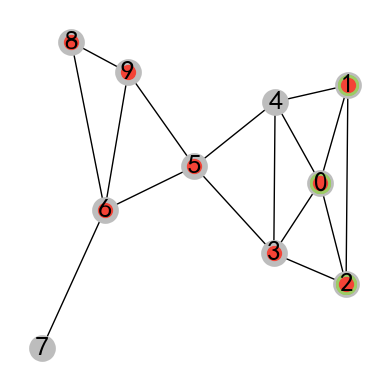

In [89]:
pq=[(1,1),(1,10),(10,1)]
walk_lsts=[]
for p,q in pq:
    node2vec_walk=usda_ge.RandomWalker(G_n2v,p=p, q=q, use_rejection_sampling=False)
    node2vec_walk.preprocess_transition_probs()
    walk_lst=node2vec_walk.node2vec_walk2(walk_length=8, start_node=0)
    walk_lsts.append(walk_lst)
print(walk_lsts)    

usda_network.G_drawing(
    G_n2v,
    node_color='#BDBDBD',
    edgecolors='#BDBDBD',
    nodes=walk_lsts[1:],
    nodes_color=['#9CCC65','#F44336'],
    nodes_size=[200,100],
    figsize=(4,4),
    )

#### 3）空手道俱乐部的 node2vec 图嵌入

该试验包括两个部分，首先用 node2vec 方法计算图嵌入；然后用顶点的嵌入向量使用`RandomForestClassifier`随机森林分类算法建立分类预测模型，计算预测精度。比较多个$p,q$值对计算结果建立分类预测模型的精度，可以发现当$p=q=1$时，即为 DeepWalk 图嵌入算法所获得的精度并不是最高的，表明配置$p,q$值合理的 node2vec 有偏随机漫步要优于 DeepWalk。

In [93]:
train_mask=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask=[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels=nodes_attri.club_int.to_numpy()

pq_pairs=[(p,q) for p in range(1,8) for q in range(1,8)]

pq_scores={}
for p,q in pq_pairs:
    model_node2vec=usda_ge.Node2Vec(G_karate_club, walk_length=10, num_walks=80,p=p, q=q, workers=1, use_rejection_sampling=1)
    model_node2vec.train(window_size=10, iter=3,embed_size=64);   

    clf=RandomForestClassifier(random_state=0)
    clf.fit(model_node2vec.w2v_model.wv[train_mask], labels[train_mask])
    
    y_pred=clf.predict(model_node2vec.w2v_model.wv[test_mask])
    acc=accuracy_score(y_pred, labels[test_mask])

    pq_scores[(p,q)]=acc

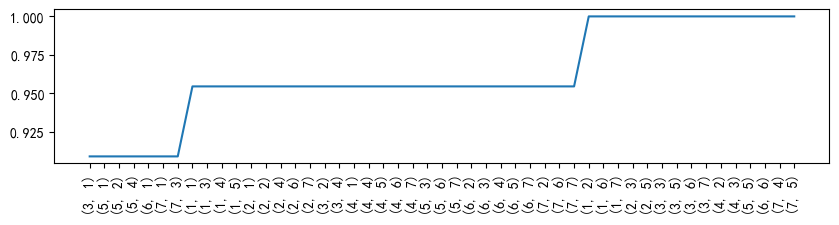

In [94]:
pq_scores_sorted=sorted(pq_scores.items(),key=lambda x:x[1])

fig,ax=plt.subplots(figsize=(10,2))
ax.plot([str(i[0]) for i in pq_scores_sorted], [i[1] for i in pq_scores_sorted], '-')
ax.tick_params(axis='x', labelrotation=90)

### 4.10.1.3 植物调查样方物种的图嵌入

[Countryside Survey 1978 vegetation plot data](https://ckan.publishing.service.gov.uk/dataset/countryside-survey-1978-vegetation-plot-data)数据集包括于1978年在英国各地调查的 256 个 $1km \times 1km$ 地块中存在的物种及其丰度（abundance）。该数据是在生态与水文中心（Centre for Ecology & Hydrology）管理的乡村调查（ Countryside Survey）长期监测项目下收集的。下载的数据集包括数据说明文件和两个数据文件，其中一个数据文件为地块的基本信息，其包含的字段如下：

1. YEAR - 调查年份；
2. SQUARE_ID - 方阵标识；
3. PLOT_ID - 地块标识；
4. PLOT_TYPE - 地块类型；
5. COUNTRY	ENV_ZONE_2007 - 环境分区编号（2007版）；
6. EZ_DESC_07 - 环境分区描述（2007版）。

另一个数据文件为调查地块中物种信息，其包含的字段如下：

1. YEAR	- 调查年份；
2. SQUARE_ID - 方阵标识；	 
3. PLOT_ID - 地块标识；	
4. AMALG_PTYPE - 地块类型；	
5. BRC_NUMBER -	物种标识；
6. BRC_NAMES - 种名；	
7. TOTAL_COVER - 占整个调查地块的百分比。	



植物群落是在一个指定的地理单元内植物物种的集合或联合（ association）<sup>Ornduff, R., Faber, P., & Keeler-Wolf, T. (2003). Introduction to California Plant Life. University of California Press.</sup>，并形成一个与相邻不同植被类型斑块区分开来相对统一的斑块。每个植物群落的组成受到土壤类型、地形、气候和人为干扰的影响<sup>[Plant community, <https://en.wikipedia.org/wiki/Plant_community>]</sup>。这里假设位于同一个调查样方中的植物物种更倾向于组成相对稳定的植物群落，从而对该数据集中植物调查样方（地块）物种构建图并计算图嵌入。构建图时，如果物种存在于同一个调查样方则建立边，并以占地百分比的差值作为边的一个属性，字段名为`cover_diff`。如果具有边连接的两个物种存在于多个调查样方中，则计算其均值。

In [4]:
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from statistics import mean 
from node2vec import Node2Vec

读取和查看植物调查数据。为了方便数据分析，使用[Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)库的`LabelEncoder`方法对物种名称进行整数编码。

In [5]:
vegetation_plot_species_list_fn='../data/Countryside_Survey_1978_vegetation_plot_data/data/Vegetation Plot - Species List 1978.csv'
vegetation_plot_information_fn='../data/Countryside_Survey_1978_vegetation_plot_data/data/Vegetation Plot - Plot Information 1978.csv'

In [6]:
species_list=pd.read_csv(vegetation_plot_species_list_fn)
le=LabelEncoder()
species_list['name_encoder']=le.fit_transform(species_list.BRC_NAMES)
species_list.tail(3)

,YEAR,SQUARE_ID,PLOT_ID,AMALG_PTYPE,BRC_NUMBER,BRC_NAMES,TOTAL_COVER,name_encoder
44492,1978,WDGZFA,GKGCGUEPMT,X,5505962.0,Cladonia sp.,1,153
44493,1978,WDGZFA,GKGCGUEPMT,X,9202136.0,Vaccinium myrtillus,1,643
44494,1978,WDGZFA,GKGCGUEPMT,X,9202138.0,Vaccinium vitis-idaea,1,646


In [7]:
plot_information=pd.read_csv(vegetation_plot_information_fn)
plot_information.tail(3)

,YEAR,SQUARE_ID,PLOT_ID,PLOT_TYPE,COUNTRY,ENV_ZONE_2007,EZ_DESC_07
2276,1978,VJURQL,PGVBRABLNM,X,ENG,3,Uplands (England)
2277,1978,VJURQL,CTDCGFAVUI,X,ENG,3,Uplands (England)
2278,1978,VJURQL,QMBXWPAQUD,X,ENG,3,Uplands (England)


按调查地块（`PLOT_ID`字段）计算两两物种的覆盖占比差值。

In [8]:
plot_species_group=species_list.groupby(by=['PLOT_ID'])

In [9]:
plot_species_group_pairs_info={}
species_pairs_percent_cover_diff_dict_list=[]

for group in tqdm(plot_species_group):
    name_encoder=group[1].name_encoder.to_list()
    species_total_cover=group[1].TOTAL_COVER.to_list()
    species_cover_dict=pd.Series(group[1].TOTAL_COVER.values,index=group[1].name_encoder).to_dict()
    species_pairs_percent_cover_diff_dict={tuple(sorted((i,j))):abs(species_cover_dict[i]-species_cover_dict[j]) for i,j in combinations(name_encoder,2)}
    species_pairs_percent_cover_diff_dict_list.append(species_pairs_percent_cover_diff_dict)

species_pairs_percent_cover_diff_dict_merged=defaultdict(list)
for d in species_pairs_percent_cover_diff_dict_list:
    for key, value in d.items():
        species_pairs_percent_cover_diff_dict_merged[key].append(value)

100%|███████████████████████████████████████████| 2279/2279 [00:00<00:00, 2697.41it/s]


In [10]:
species_pairs_percent_cover_diff_mean={k:mean(v) for k,v in species_pairs_percent_cover_diff_dict_merged.items()} 

构建图。

In [12]:
species_encoder2name=pd.Series(species_list.BRC_NAMES.values,index=species_list.name_encoder).to_dict()

G_species=nx.Graph()
G_species.add_edges_from(list(species_pairs_percent_cover_diff_mean.keys()))
nx.set_edge_attributes(G_species, species_pairs_percent_cover_diff_mean,'cover_diff')
nx.set_node_attributes(G_species,species_encoder2name,'name')

计算图嵌入。此次试验使用的`node2vec`算法是直接调用[Node2Vec](https://github.com/eliorc/node2vec)库提供的方法。实验中配置参数`p,q`不同值，计算了两次图嵌入，可以发现不同的`p,q`值将会有不同的结果。因此在实际问题分析时，需要根据分析目的权衡同质性和结构等效性，分析群落结构性的特征。

In [145]:
node2vec=Node2Vec(G_species, dimensions=64, walk_length=30, num_walks=200, p=.1, q=10, workers=8)
model_pq=node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|███████████| 675/675 [02:30<00:00,  4.49it/s]


用计算获得的图嵌入矩阵（向量），定义`most_similar_species()`函数，给定物种名返回与该物种在网络结构中相似，距离相近的物种列表。

In [146]:
def most_similar_species(species_name,species_encoder2name,model,num=10):
    species_name2encoder={v:k for k,v in species_encoder2name.items()}
    species_similar=model.wv.most_similar(species_name2encoder[species_name])
    species_similar_nameNencoder=[(i[0],species_encoder2name[int(i[0])],i[1]) for i in species_similar]
    
    species_encoder=species_name2encoder[species_name]
    return species_similar_nameNencoder,species_encoder       

species_similar_nameNencoder_pq,species_encoder=most_similar_species('Avena fatua',species_encoder2name,model_pq) 
species_similar_nameNencoder_pq

[('132', 'Centaurea nigra', 0.6480474472045898),
 ('521', 'Rumex acetosa', 0.6247394680976868),
 ('627', 'Trifolium pratense', 0.6161571741104126),
 ('477', 'Prunella vulgaris', 0.5903562307357788),
 ('98', 'Cardamine pratensis', 0.5866711139678955),
 ('470', 'Potentilla erecta', 0.5834638476371765),
 ('136', 'Cerastium fontanum', 0.583010196685791),
 ('628', 'Trifolium repens', 0.5810055732727051),
 ('605', 'Succisa pratensis', 0.57342928647995),
 ('469', 'Potentilla anserina', 0.5671511888504028)]

计算给定物种和其相似物种之间的最短路径，例如对于物种 Avena fatua（60）到嵌入向量空间中距离最近的物种为 Centaurea nigra（132），但是在所有的调查地块中，这两个物种并没有同时出现，而是存在一个中间物种 Achillea millefolium。而对于相似物种 Trifolium pratense（627），则存在边，即存在同时出现的地块。

In [154]:
shortest_path_st_pq={i[0]:[G_species.has_edge(int(species_encoder),int(i[0])),nx.shortest_path(G_species,source=int(species_encoder),target=int(i[0])) ] for i in species_similar_nameNencoder_pq}
shortest_path_st_pq

{'132': [False, [60, 2, 132]],
 '521': [False, [60, 10, 521]],
 '627': [True, [60, 627]],
 '477': [False, [60, 12, 477]],
 '98': [False, [60, 48, 98]],
 '470': [False, [60, 183, 470]],
 '136': [True, [60, 136]],
 '628': [True, [60, 628]],
 '605': [False, [60, 10, 605]],
 '469': [False, [60, 12, 469]]}

In [156]:
species_encoder2name[2]

'Achillea millefolium'

在图中显示给定物种及通过图嵌入计算获得的相似物种。

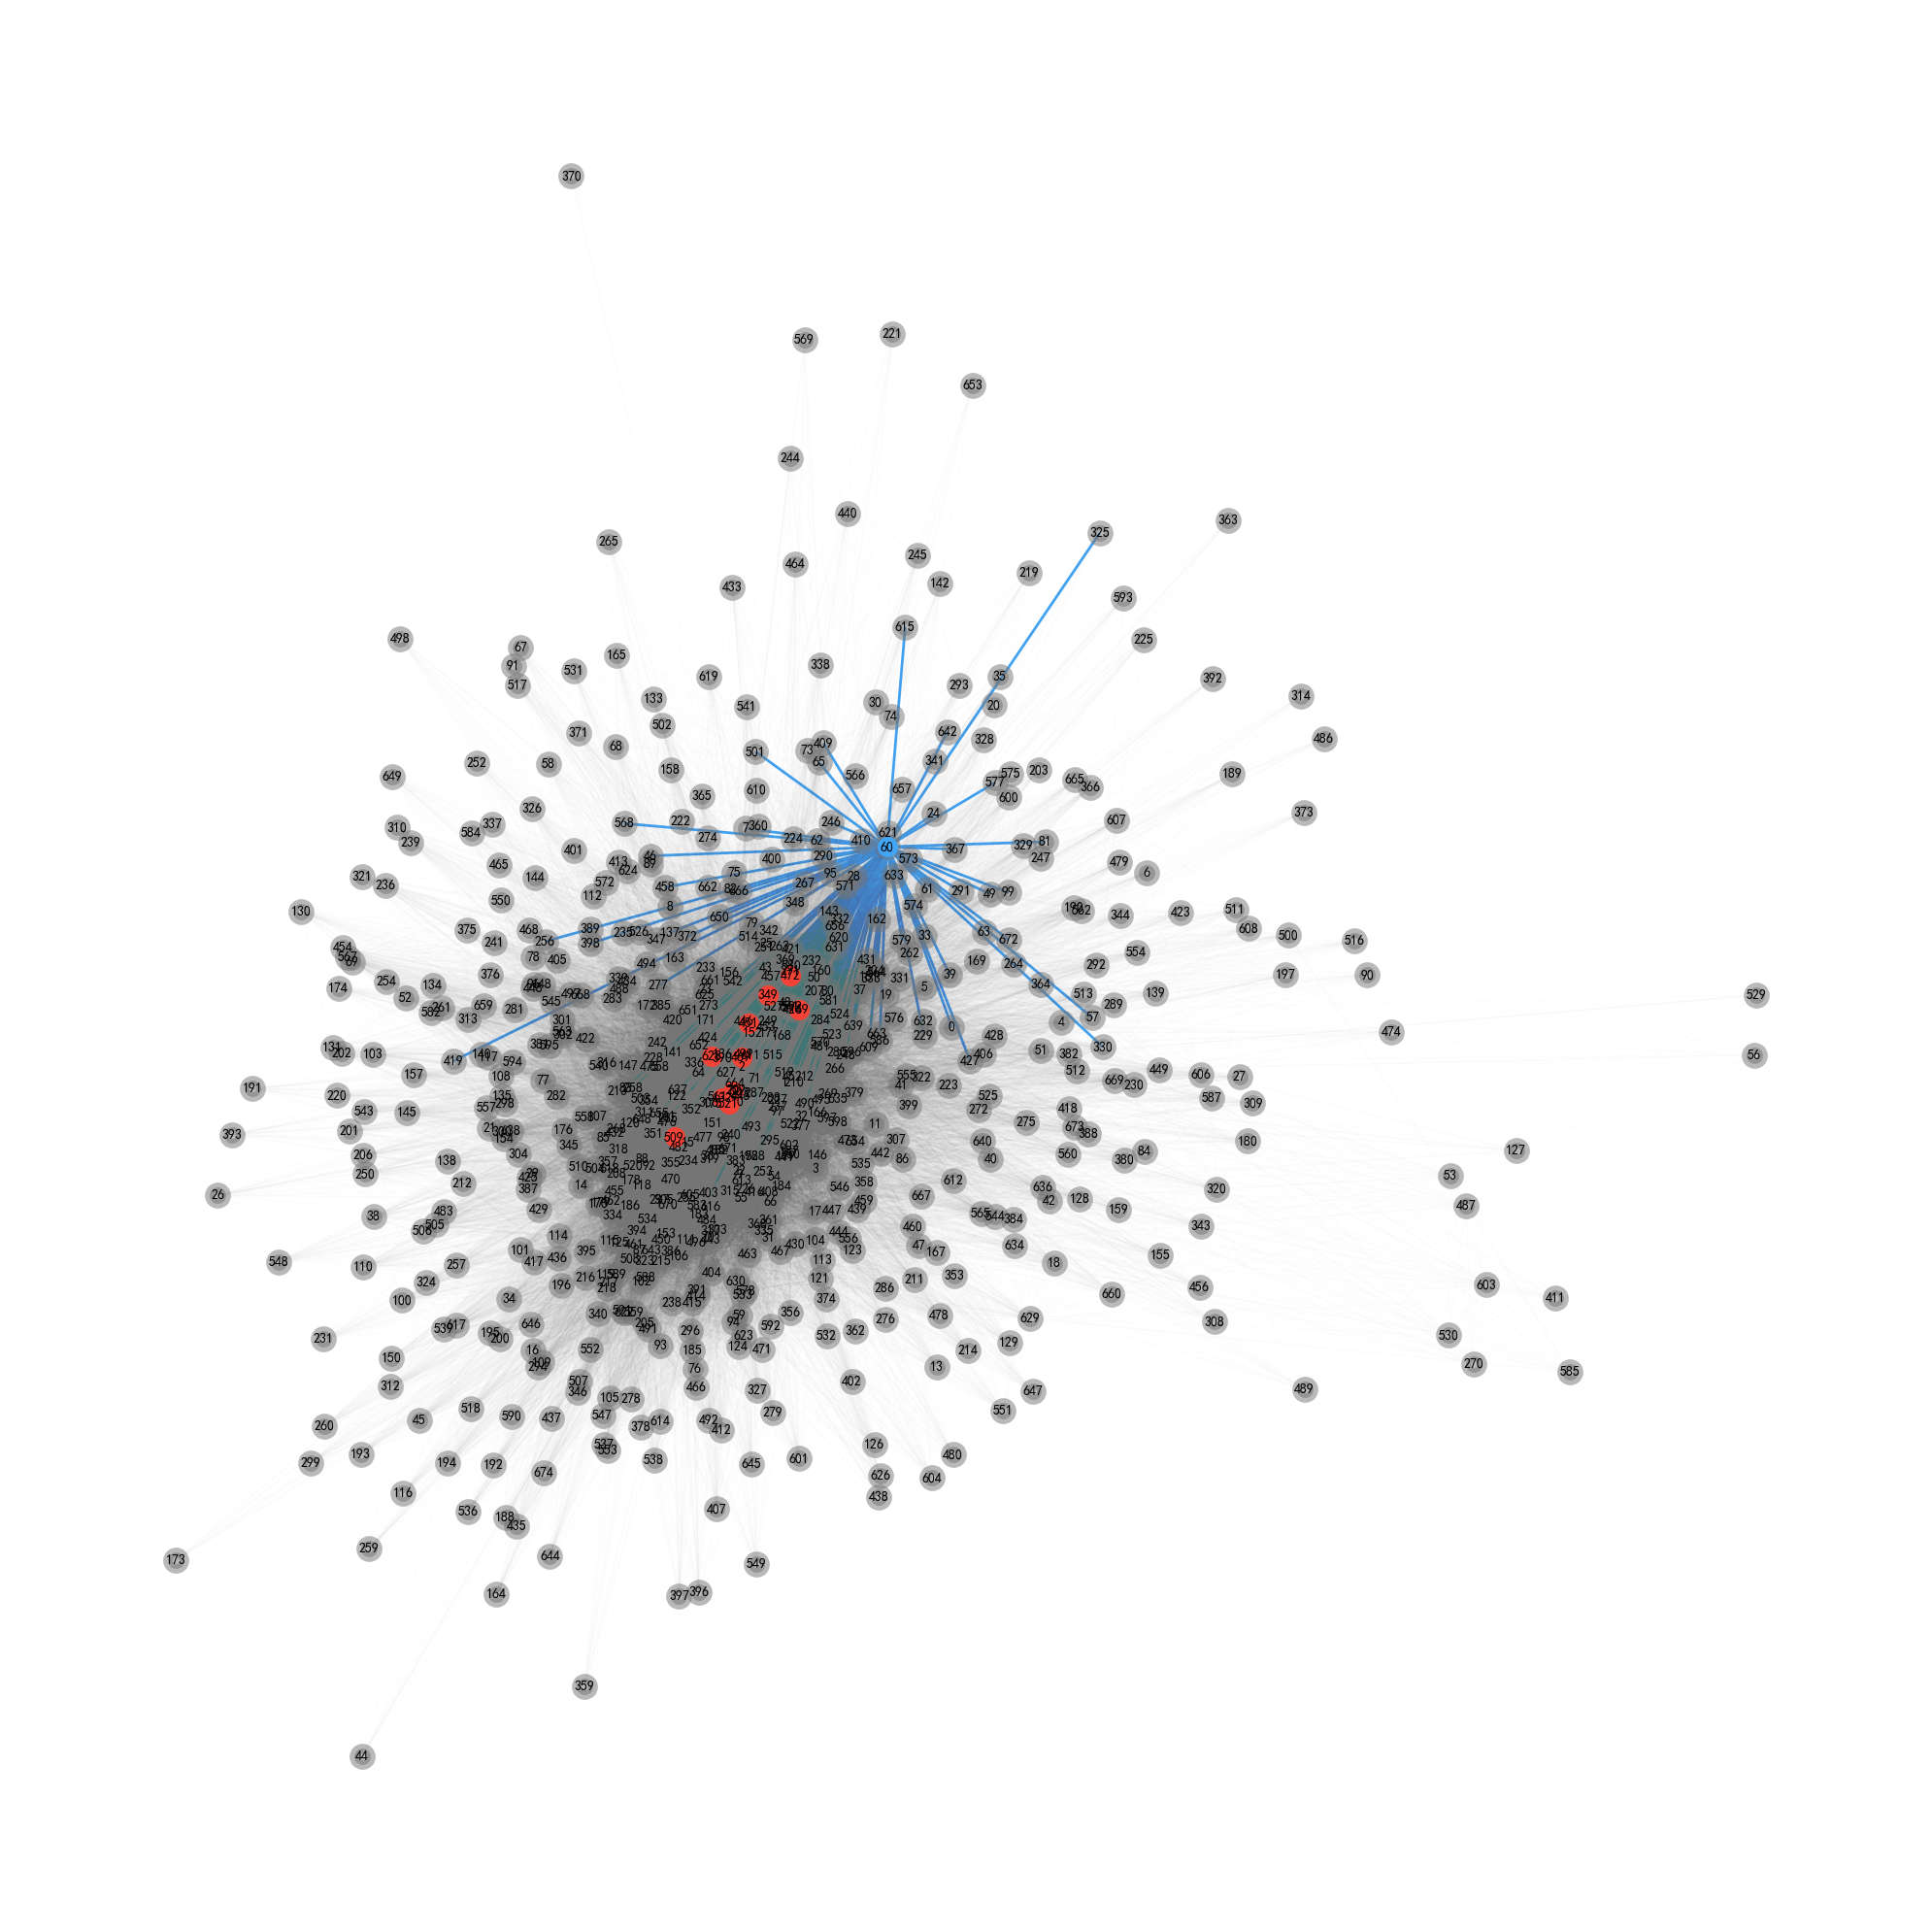

In [133]:
species_edges=list(G_species.edges(species_encoder))

similar_nodes=[[species_encoder],[int(i[0]) for i in species_similar_nameNencoder_pq]]
usda_network.G_drawing(G_species,
                       figsize=(20,20),
                       edge_widths=[2]*len(species_edges),
                       nodes=similar_nodes,nodes_color=['#42A5F5','#F44336'],
                       routes=species_edges,
                       edge_colors=['#42A5F5']*len(species_edges),
                       edge_color=(117/255,117/255,117/255,.01),
                       font_size=10,
                       node_color=(117/255,117/255,117/255,.5),
                       edgecolors=(117/255,117/255,117/255,.5),
                       )

调整`p,q`值，再次计算图嵌入，观察计算结果发现，对于同一给定物种 Avena fatua（60）的相似物种发生的变化。

In [150]:
node2vec=Node2Vec(G_species, dimensions=64, walk_length=30, num_walks=200, p=2, q=1, workers=8)
model_qp=node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|███████████| 675/675 [02:32<00:00,  4.43it/s]


In [151]:
species_similar_nameNencoder_qp,species_encoder=most_similar_species('Avena fatua',species_encoder2name,model_qp) 
shortest_path_st={i[0]:[G_species.has_edge(int(species_encoder),int(i[0])),nx.shortest_path(G_species,source=int(species_encoder),target=int(i[0])) ] for i in species_similar_nameNencoder_qp}
shortest_path_st

{'315': [False, [60, 12, 315]],
 '151': [False, [60, 2, 151]],
 '319': [False, [60, 10, 319]],
 '208': [False, [60, 2, 208]],
 '240': [False, [60, 12, 240]],
 '521': [False, [60, 10, 521]],
 '493': [False, [60, 2, 493]],
 '253': [False, [60, 12, 253]],
 '175': [False, [60, 136, 175]],
 '209': [True, [60, 209]]}

## 4.10.2 从 原始（vanilla） GNN 到 GCN、GAT、GraphSAGE 和 GIN <sup>[Labonne, M. (2023). Hands-On Graph Neural Networks Using Python (1st ed.). Packt Publishing. (Original work published 2023)][Understanding Convolutions on Graphs, <https://distill.pub/2021/understanding-gnns/>.]</sup>


In [35]:
%load_ext autoreload 
%autoreload 2 
import usda.network as usda_nx

import torch
from torch_geometric.datasets import FacebookPagePage
from torch_geometric.datasets import PPI
from torch_geometric.utils import to_dense_adj

from sklearn.metrics import f1_score
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_batch
from torch.nn import LSTM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
usda_nx.gnn_algorithms_dash()

### 4.10.2.1 vanilla (多层感知机，Multi-Layer Perceptron（MLP）) GNN（vGNN）

一个基本的神经网络层对应一个线性变换（linear transformation），公式表达为$h_A=x_A W^T$，式中，$x_A$为顶点$A$的输入向量（特征向量）；$W$为权重。如果构建 MLP 直接学习特征向量（输出为顶点对应的一个分类），将忽略顶点之间边的联系，使得顶点间完全分离，网络学习不到图中顶点的语境，训练的模型预测精度必然不高。如果考虑顶点邻接顶点的特征，设$\mathcal{N_A}$为顶点$A$的邻接顶点（含自身），则可以将图的线性层（graph linear layer）调整为，$h_A=\sum_{i \in \mathcal{N}_A} x_i W^T$。下图简单示例中，假设图含有5个顶点，并仅包含一个特征（特征向量的维度为1），对于顶点$A$，结果为 -1，经激活函数（ReLU）非线性变换后结果为0。

<img src="../imgs/4_10_4/4_10_4_04.png" height='auto' width='700' title="caDesign"> 

将线性变换转换为矩阵表达有$H=X W^T$，式中$X$为顶点的输入特征向量矩阵。同样将图线性层的上述公式转换为矩阵表达有$H=\tilde{\mathrm{A}}^T X W^T$，式中$\tilde{\mathrm{A}}$为包含自身的顶点邻接矩阵（方阵），为$\tilde{\mathrm{A}}=A+I$，式中$A$为邻接矩阵，$I$为单位矩阵（identity matrix）。用 0 表示两个顶点间不邻接，用 1 表示邻接。矩阵的对角线为顶点自身之间的关系，如果值为 1， 则包含自身。

[PyG （PyTorch Geometric）](https://pytorch-geometric.readthedocs.io/en/latest/index.html)是一个基于 [PyTorch](https://pytorch.org/)构建的库，可以轻松编写和训练神经网络（Graph Neural Networks，GNNs），广泛用于与结构化数据相关的应用。PyG 的 [datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)模块包含有大量图数据集，其中 Facebook 为经过验证页面-页面（page-page）的图数据集。顶点对应到官方的 Facebook 页面，边对应到互相点赞（likes）的站点。顶点特征为对站点的描述，任务是对站点类别进行多类别分类<sup>Benedek Rozemberczki, Carl Allen, Rik Sarkar, Multi-Scale attributed node embedding, Journal of Complex Networks, Volume 9, Issue 2, April 2021, cnab014, https://doi.org/10.1093/comnet/cnab014</sup>。构建 vGNN 网络，用 Facebook 图数据集训练模型，完成分类任务。 

下载和读取 Facebook 图数据集。

In [2]:
facebookPagePage_fn='../data/pyg_datasets'
dataset=FacebookPagePage(root=facebookPagePage_fn)

查看数据集相关信息。

In [3]:
data=dataset[0]
print(f'number of graphs:{len(dataset)}\
        \nnumber of nodes:{data.x.shape[0]}\
        \nnumber of features:{dataset.num_features}\
        \nnumber of classes:{dataset.num_classes}\
        \nedges are directed:{data.is_directed()}\
        \ngraph has isolated nodes:{data.has_isolated_nodes()}\
        \ngraph has loops:{data.has_self_loops()}')

number of graphs:1        
number of nodes:22470        
number of features:128        
number of classes:4        
edges are directed:False        
graph has isolated nodes:False        
graph has loops:True


查看顶点属性特征向量，和对应的站点类别。

In [4]:
print(data.x.shape,'\n',data.x,'\n',data.y)

torch.Size([22470, 128]) 
 tensor([[-0.2626, -0.2765, -0.2624,  ..., -0.2151, -0.3759, -0.2238],
        [-0.2626, -0.2765, -0.2624,  ..., -0.2151, -0.3641, -0.1286],
        [-0.2626, -0.2651, -0.2624,  ..., -0.2151, -0.3759, -0.2238],
        ...,
        [-0.2626, -0.2765, -0.2624,  ..., -0.1804, -0.3721, -0.2226],
        [-0.2626, -0.2765, -0.2624,  ..., -0.2151, -0.3759, -0.2181],
        [-0.2323, -0.2765, -0.2624,  ..., -0.1959, -0.3759, -0.2213]]) 
 tensor([0, 2, 1,  ..., 2, 1, 0])


采用 `PyG` 库对图数据处理的方法，配置训练、验证和测试数据集区间。

In [5]:
data.train_mask=range(18000)
data.val_mask=range(18001, 20000)
data.test_mask=range(20001, 22470)

用`PyG`的`to_dense_adj`方法计算顶点邻接矩阵，并配置对角线值为 1，即包含顶点自身。

In [6]:
adjacency=to_dense_adj(data.edge_index)[0]
adjacency+=torch.eye(len(adjacency))
print(adjacency.shape)
adjacency

torch.Size([22470, 22470])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

查看 vGNN 网络层，定义有两个线性层，执行完一个线性层计算后，计算与顶点邻接矩阵的点积（点乘），代码为`x = torch.sparse.mm(adjacency, x)`，然后经激活函数（ReLU）非线性变换后，执行第2个线性层，最后用 SoftMax 函数分类，使用 `PyTorch`库的`torch.nn.functional.log_softmax`方法。

In [108]:
gnn_vanilla=usda_nx.VanillaGNN(dataset.num_features, 16, dataset.num_classes)
gnn_vanilla

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)

训练模型。预测精度为预测分类正确数的百分比。

In [114]:
gnn_vanilla.fit(data,adjacency,epochs=1000,verbose=200)

Epoch   0 | Train Loss: 1.309 | Train Acc: 79.72% | Val Loss: 1.25 | Val Acc: 79.24%
Epoch 200 | Train Loss: 0.324 | Train Acc: 91.18% | Val Loss: 0.36 | Val Acc: 90.80%
Epoch 400 | Train Loss: 0.294 | Train Acc: 92.40% | Val Loss: 0.34 | Val Acc: 90.70%
Epoch 600 | Train Loss: 0.241 | Train Acc: 93.25% | Val Loss: 0.32 | Val Acc: 91.10%
Epoch 800 | Train Loss: 0.204 | Train Acc: 93.88% | Val Loss: 0.31 | Val Acc: 91.30%
Epoch 1000 | Train Loss: 0.574 | Train Acc: 89.84% | Val Loss: 0.62 | Val Acc: 89.59%


用测试数据集查看多类别分类预测精度，结果为 88.62%。

In [116]:
acc=gnn_vanilla.test(data,adjacency)
print(f'\nGNN test accuracy: {acc*100:.2f}%')


GNN test accuracy: 88.62%


C:\Users\richie\anaconda3\envs\rl\Lib\site-packages\usda\network\_gnn_interpretation.py:325: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

C:\Users\richie\anaconda3\envs\rl\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



### 4.10.2.2 GCN（Graph Convolutional Networks）

基于卷积神经网络（Convolutional Neural Networks，CNNs），Thomas N. Kipf等人<sup>[Thomas N. Kipf, & Max Welling (2017). Semi-Supervised Classification with Graph Convolutional Networks. In 5th International Conference on Learning Representations, ICLR 2017, Toulon, France, April 24-26, 2017, Conference Track Proceedings. OpenReview.net.]</sup>提出了用于复杂网络的图卷积网络（Graph Convolutional Networks，GCNs）。不同于vGNN，仅是加权求和顶点与其邻接顶点的特征值，GCN考虑到当前顶点度，有$h_i=\frac{1}{\operatorname{deg}(i)} \sum_{j \in N_i} x_j W^\tau$，式中$\operatorname{deg}(i)$为当前顶点度；对应矩阵的形式表示为$H=\tilde{D}^{-1} \tilde{A} X W^T$，式中，$\tilde{A}=A+I$，$A$为邻接矩阵，$I$为单位矩阵，为包含当前顶点自身。$\tilde{D}^{-1}=(D+I)^{-1} $，为顶点度倒数矩阵。Thomas N. Kipf等人注意到，具有更高顶点度，即具有更多邻接顶点的顶点的特征更容易传播。为了抵消这种影响，提出了$H=\tilde{D}^{-\frac{1}{2}} \tilde{A}^T \tilde{D}^{-\frac{1}{2}} X W^T$，可以使得低顶点度的顶点分配有更高的权重。就单个顶点，GCN 的计算公式为$h_i=\sum_{j \in N_i} \frac{1}{\sqrt{\operatorname{deg}(i)} \sqrt{\operatorname{deg}(j)}} x_j W^T$。

下图简单示例中，配置权重值$W=1$（因此可以省略），对于顶点$A$，其自身顶点度为3（有 2 个邻接顶点，并包含自身），其特征值为 6， 因此根据单个顶点的 GCN 公式有，$6 \times   \frac{1}{ \sqrt{3} \times \sqrt{3}} $；对于$A$的邻接顶点$E$，其顶点度为4，特征值为 3，因此有$3 \times   \frac{1}{ \sqrt{3} \times \sqrt{4}} $；同理，对于邻接顶点$C$有，$-10 \times   \frac{1}{ \sqrt{3} \times \sqrt{2}} $。将上述各邻接顶点（含自身）结果求和后结果为 -1.216，经激活函数（ReLU）非线性变换后结果为0。

<img src="../imgs/4_10_4/4_10_4_05.png" height='auto' width='700' title="caDesign"> 

`PyG`集成有大量[卷积层（Convolutional Layers）](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)，其中`GCNConv`对应到Thomas N. Kipf等人提出的方法。使用`GCNConv`层定义 GCN，如下包含有两层`GCNConv`。同样使用 Facebook 图数据集进行试验。

In [97]:
gcn=usda_nx.GCN(dataset.num_features, 16, dataset.num_classes)
gcn

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)

In [103]:
gcn.fit(data, epochs=1000,verbose=200)

Epoch   0 | Train Loss: 0.236 | Train Acc: 93.09% | Val Loss: 0.24 | Val Acc: 92.35%
Epoch 200 | Train Loss: 0.153 | Train Acc: 95.67% | Val Loss: 0.20 | Val Acc: 93.75%
Epoch 400 | Train Loss: 0.144 | Train Acc: 96.01% | Val Loss: 0.20 | Val Acc: 93.90%
Epoch 600 | Train Loss: 0.141 | Train Acc: 96.04% | Val Loss: 0.19 | Val Acc: 94.00%
Epoch 800 | Train Loss: 0.139 | Train Acc: 96.12% | Val Loss: 0.19 | Val Acc: 93.90%
Epoch 1000 | Train Loss: 0.138 | Train Acc: 96.13% | Val Loss: 0.19 | Val Acc: 93.90%


用测试数据集查看多类别分类预测精度，结果为 93.16%。

In [104]:
acc=gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')


GCN test accuracy: 93.16%



### 4.10.2.3 GAT（Graph Attention Networks）

在*从 RNN 到 Transformer 和 GPT，从自然语言处理到视觉模型*部分解释了 transformer 网络中的注意力机制，将该机制用于 GNN 建立  GAT（Graph Attention Networks）。相较于 GCN 考虑顶点度以区分邻接顶点少的顶点比其它顶点更重要，GAT 则引入了考虑顶点特征重要性的加权因子，为顶点间的注意力得分（attention score），对于顶点$i,j$间的注意力得分，可记为$a_{ij}$，从而有，$h_i=\sum_{j \in \mathcal{N}_i} \alpha_{i j} \mathbf{W} x_j$。该公式对应到下图顶点$A$示例$h_A$的计算部分，其中，$a_{AA},a_{AC},a_{AE}$分别为顶点$A$到邻接顶点的注意力得分（含自身）。

注意力得分$a_{ij}$的计算包括线性变换（Linear transformation），应用激活函数（Activation function）和 Softmax 标准化（ Softmax normalization）。组合线性变换和激活函数可表示为，$e_{i j}=\operatorname{LeakyReLU}\left(W_{a t t}^\tau\left[\mathbf{W} h_i \| \mathbf{W} h_j\right]\right) $，对应到下图示例中$e_{AA},e_{AC},e_{AE}$的计算部分，式中，$W$为共享的权重矩阵；$W_{att}$对应图中示例的$A_W$权重矩阵。对线性变换结果执行 LeakyReLU 激活函数，对 LeakyReLU 的解释可以查看*判别器（D）的层结构*部分，其公式表述为$\operatorname{LeakyReLU}(x)=\max (0, x)+$ negative_slope $* \min (0, x)$，或$\text { LeakyReLU }(x)= \begin{cases}x, & \text { if } x \geq 0 \\ \text { negative\_slope } \times x, & \text { otherwise }\end{cases}$。LeakyReLU 的计算直接调用`PyTorch`库的`torch.nn.LeakyReLU(negative_slope=0.01, inplace=False)`方法，在下图示例计算时，配置参数`negative_slope=0.2`。

如果要比较不同的注意力得分，则需要将其标准化，使用 Softmax 标准化方法，公式为$\alpha_{i j}=\operatorname{softmax}_j\left(e_{i j}\right)=\frac{\exp \left(e_{i j}\right)}{\sum_{k \in \mathcal{N}_i} \exp \left(e_{i k}\right)}$，对应图中$a_{AA},a_{AC},a_{AE}$部分的计算。实际计算时调用`torch.nn.Softmax(dim=None)`方法。

<img src="../imgs/4_10_4/4_10_4_06.jpeg" height='auto' width='1000' title="caDesign"> 

由于自注意力（self-attention）可能并不稳定，因此 Vaswani, A. 等人<sup>[ Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention Is All You Need. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1706.03762]</sup>提出了多头注意力（Multi-head attention ），在 GAT 中则是将线性变换，应用激活函数和 Softmax 标准化过程重复多次（$n$）计算，而后取均值或只是连接（Concatenation），对于取均值可表示为，$ h_i=\frac{1}{n} \sum_{k=1}^n h_i^k=\frac{1}{n} \sum_{k=1}^n \sum_{j \in N_i} \alpha_{i j}^k \mathbf{W}^k x_j$；对于连接可表示为，$h_i=\|_{k=1}^n h_i^k=\|_{k=1}^n \sum_{j \in N_i} \alpha_{i j}^k \mathbf{W}^k x_j $。实践中，为隐藏层时选择连接方式，当位于网络最后一层时选择均值方式。

Shaked Brody 等人<sup>[Shaked Brody, Uri Alon, & Eran Yahav (2022). How Attentive are Graph Attention Networks? . In International Conference on Learning Representations.]</sup>发现 GAT 计算的是一种非常有限的注意力：注意力得分排名在查询的顶点上是无条件的。为与更具表现力的动态注意力（dynamic attention）区分，将这种受限的注意力定义为静态注意力（static attention）。使用静态注意力机制的 GAT 不能表示简单图问题（ simple graph problems），在受控问题（controlled problem）中甚至会阻碍训练数据拟合。为了消除静态注意力的限制，Shaked Brody 等人通过调整 GAT 的计算顺序提出了 GATv2。对 GAT 中计算$e_{ij}$的公式进行调整，有$e_{i j}=W_{a t t}^\tau \operatorname{LeakyReLU}\left( \mathbf{W} \left[ h_i \|  h_j\right]\right) $。`PyG` 库对则应提供了`GATConv`和`GATv2Conv`方法。

继续使用 Facebook 图数据集进行试验，计算过程和结果如下。

In [8]:
gat=usda_nx.GATv2(dataset.num_features, 32, dataset.num_classes)
gat

GATv2(
  (gat1): GATv2Conv(128, 32, heads=8)
  (gat2): GATv2Conv(256, 4, heads=1)
)

In [9]:
gat.fit(data,epochs=1000,verbose=200)

Epoch   0 | Train Loss: 2.047 | Train Acc: 22.72% | Val Loss: 2.02 | Val Acc: 22.56%
Epoch 200 | Train Loss: 0.331 | Train Acc: 89.11% | Val Loss: 0.33 | Val Acc: 89.39%
Epoch 400 | Train Loss: 0.323 | Train Acc: 88.94% | Val Loss: 0.31 | Val Acc: 89.19%
Epoch 600 | Train Loss: 0.339 | Train Acc: 88.44% | Val Loss: 0.34 | Val Acc: 88.29%
Epoch 800 | Train Loss: 0.332 | Train Acc: 88.81% | Val Loss: 0.33 | Val Acc: 89.34%
Epoch 1000 | Train Loss: 0.330 | Train Acc: 88.50% | Val Loss: 0.32 | Val Acc: 89.29%


用测试数据集查看多类别分类预测精度，结果为 91.17%。

In [10]:
acc=gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 91.17%


### 4.10.2.4 GraphSAGE

大型图中顶点的低维嵌入（low-dimensional embeddings）已经被证明在各种预测任务中非常有用，为了避免训练嵌入时包含图中所有的顶点（称为直推式，（transductive）），Hamilton, W.等人<sup>[Hamilton, W., Ying, Z. & Leskovec, J. (2017). Inductive Representation Learning on Large Graphs. Advances in Neural Information Processing Systems, , 1024-1034.]</sup>提出了 GraphSAGE 算法，一个通用的归纳式（inductive）框架，利用顶点特征信息，从顶点的局部邻域中采样和聚合特征学习一个函数，不是为每个顶点训练一个不同的嵌入向量，而是训练一组聚合器函数（aggregator functions），从而有效的为之前未见过的数据生成顶点嵌入。其具体的过程如下图示<sup>[previous one]</sup>：

<img src="../imgs/4_10_4/4_10_4_08.png" height='auto' width='1000' title="caDesign"> 

上图中，左图为邻域采样；中图为从邻域采样中聚合特征信息；右图为使用聚合的信息预测图的上下文（context）和类标。

* 邻域采样（Neighbor sampling）

聚合器函数从远离给定顶点不同跳数（hops）或搜索深度聚合信息。从上图左中可以观察 1 跳为顶点的邻接顶点，2 跳为邻接顶点的邻接顶点，以此类推。同时，为了避免对应跳数顶点数的指数级增长，采用邻域采样的方式降低顶点数。

* 聚合器架构（Aggregator Architectures）

聚合器函数作用于没有自然顺序的邻接顶点。理想情况，聚合器函数应是对称（对其输入的排列不变）且是可训练的，保持有较高的表示能力，从而保证神经网络模型可以被训练并应用于任意有序的顶点邻域特征集。论文中作者研究了三种聚合器函数，为均值、LSTM 和池化（Pooling）。

均值算子是计算邻域采样$\left\{\mathbf{h}_u^{k-1}, \forall u \in \mathcal{N}(v)\right\} $中顶点向量的均值，基本等同于 GCN 的卷积传播规则，用公式表示为$ \mathbf{h}_v^k \leftarrow \sigma\left(\mathbf{W} \cdot \operatorname{MEAN}\left(\left\{\mathbf{h}_v^{k-1}\right\} \cup\left\{\mathbf{h}_u^{k-1}, \forall u \in \mathcal{N}(v)\right\}\right)\right.$；LSTM 聚合器基于 LSTM 架构（可以参考*从 RNN 到 Transformer 和 GPT，从自然语言处理到视觉模型*章节对 LSTM 的阐述），与均值聚合器相比，LSTM 聚合器理论上可以区分更多的图结构，从而生成更好的嵌入。但 LSTM 输入为一个序列，而顶点没有任何顺序，因此需要对顶点进行随机排序，例如在 `PyG` 中使用`data.sort(sort_by_row=False)`方法按照边索引的目标顶点排序等；池化聚合器，将邻域采样每个顶点的向量喂入全连接神经网络，而后用最大池化（max-pooling）聚合信息，公式表达为$\quad \operatorname{AGGREGATE}_k^{\text {pool }}=\max \left(\left\{\sigma\left(\mathbf{W}_{\text {pool }} \mathbf{h}_{u_i}^k+\mathbf{b}\right), \forall u_i \in \mathcal{N}(v)\right\}\right)$，式中，$max$表示取最大值，$\sigma$为非线性激活函数。原则上，在最大池化之前应用的函数可以是任意深度的多层感知器。

下图单个顶点的 GraphSAGE 更新演示使用 LSTM 聚合器函数。为了方便演示，配置 LSTM 的所有参数均为值1。通过按照边索引（`edge_index`）的目标顶点排序，得到如下边索引结果`data.edge_index`。按照边索引，使用`PyG`的`to_dense_batch`方法，按照排序后的边索引，可以得到图中每个顶点邻接顶点向量`x_dense`。如果不足最大邻接顶点数，则用值0占位，例如对于顶点$A$，其邻接顶点为$C,E$，有`[[-10.],[2.],[0.]]`。

In [38]:
x=torch.tensor([[6],[2],[-10],[1],[3]]).to(torch.float)
edge_index=torch.tensor([[0, 0, 1, 2, 3, 4, 4, 4],[2, 4, 4, 0, 4, 0, 1, 3]])
data=Data(x=x, edge_index=edge_index)

data=data.sort(sort_by_row=False)
data.edge_index

tensor([[2, 4, 4, 0, 4, 0, 1, 3],
        [0, 0, 1, 2, 3, 4, 4, 4]])

In [39]:
x_=torch.tensor([data.x[i] for i in data.edge_index[0]]).reshape(-1,1)
x_dense,_=to_dense_batch(x_,data.edge_index[1])
x_dense

tensor([[[-10.],
         [  3.],
         [  0.]],

        [[  3.],
         [  0.],
         [  0.]],

        [[  6.],
         [  0.],
         [  0.]],

        [[  3.],
         [  0.],
         [  0.]],

        [[  6.],
         [  2.],
         [  1.]]])

用 LSTM 模型计算按边索引目标顶点排序的邻接顶点向量结果如下。

In [40]:
lstm=LSTM(1, 1, batch_first=True)
for para in list(lstm.parameters()):   
    para.data.fill_(1.0)

lstm_out=lstm(x_dense)[0][:,-1] 
lstm_out

tensor([[0.8961],
        [0.9393],
        [0.9395],
        [0.9393],
        [0.9756]], grad_fn=<SelectBackward0>)

完成聚合器函数（LSTM）计算后，对应演示后续计算公式表示为$h_i^{\prime}=\sigma\left(\mathbf{W} h_i+\mathbf{B} \cdot \operatorname{LSTM}_{j \in \mathcal{N}_i}\left(h_j\right)\right)$。

<img src="../imgs/4_10_4/4_10_4_07.png" height='auto' width='700' title="caDesign"> 

直推式只能生成固定图的嵌入，不能泛化到不可见的顶点或图。而基于邻域采样，GraphSAGE 被设计成在局部使用修剪后的计算图进行预测的归纳式架构，从而可用于具有相同特征模式的任何计算图。使用`PyG`提供的蛋白质间相互作用网络图数据集`PPI`<sup>[Marinka Zitnik, Jure Leskovec, Predicting multicellular function through multi-layer tissue networks, Bioinformatics, Volume 33, Issue 14, July 2017, Pages i190–i198, https://doi.org/10.1093/bioinformatics/btx252]</sup>，包含定位基因（positional gene）集，基序基因（motif gene）集，作为顶点特征的免疫特征（immunological signatures）数据（总共有 50 个），并将基因本体集（gene ontology）作为标签（总共 121 个）。直接迁移 *Hands-On Graph Neural Networks Using Python*<sup>[Labonne, M. (2023). Hands-On Graph Neural Networks Using Python (1st ed.). Packt Publishing. (Original work published 2023)]137</sup>示例代码计算过程和结果如下。

查看 GPU。

In [42]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2.1.0+cu118


device(type='cuda')

下载数据至本地磁盘。

In [48]:
# Load training, evaluation, and test sets
root='../data/pyg_datasets/PPI'
train_dataset= PPI(root=root, split='train')
val_dataset = PPI(root=root, split='val')
test_dataset = PPI(root=root, split='test')

print(len(train_dataset))
train_dataset[0]

20


Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])

训练数据集包括 20 个图，将这些所有图通过`Batch.from_data_list`方法将其描述为一个不连接的大图（统一成一个集合），并建立用于训练的数据加载器。

In [51]:
# Unify the training graphs and apply neighbor sampling
train_data = Batch.from_data_list(train_dataset)
train_loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Evaluation loaders (one datapoint corresponds to a graph)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

train_data

DataBatch(x=[44906, 50], edge_index=[2, 1226368], y=[44906, 121], batch=[44906], ptr=[21])

初始化 GraphSAGE 模型，损失和优化器。

In [6]:
model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model

GraphSAGE(50, 121, num_layers=2)

定义模型训练函数。

In [7]:
def fit(loader):
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.data)

定义精度计算函数，使用对应于准确率和召回率的调和平均值`f1_score`（f1-分数）。

In [8]:
@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

训练模型。

In [9]:
for epoch in range(1001):
    loss = fit(train_loader)
    val_f1 = test(val_loader)
    if epoch % 200 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

print(f'Test F1-score: {test(test_loader):.4f}')

Epoch   0 | Train Loss: 12.720 | Val F1-score: 0.4894
Epoch 200 | Train Loss: 8.501 | Val F1-score: 0.8194
Epoch 400 | Train Loss: 8.431 | Val F1-score: 0.8319
Epoch 600 | Train Loss: 8.398 | Val F1-score: 0.8317
Epoch 800 | Train Loss: 8.362 | Val F1-score: 0.8373
Epoch 1000 | Train Loss: 8.368 | Val F1-score: 0.8341
Test F1-score: 0.8570


查看已训练模型的预测精度。

In [52]:
print(f'Test F1 score: {test(test_loader):.4f}')

Test F1 score: 0.8570


### 4.10.2.5 GIN

---

In [17]:
%load_ext autoreload 
%autoreload 2

import torch
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils.convert import from_networkx
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np

from torch_geometric.nn import GATv2Conv,GATConv,SAGEConv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
class GraphConstructor:
    @classmethod
    def data(cls):
        nodes = [
            {
                'data': {'id': short, 'label': f'{label}({f_1})','value':short,'feature':f_1},
                'position': {'x': lat, 'y': long},   
                'selected':True,
            } if short=='A' else
            {
                'data': {'id': short, 'label': f'{label}({f_1})','value':short,'feature':f_1},
                'position': {'x': lat, 'y': long},   
                'selected':False,
            }       
            for short, label, f_1,long, lat in (
                ('A', 'A', 6,1, 1),
                ('B', 'B', 2,2, 2),
                ('C', 'C', -10,1, 2),
                ('D', 'D', 1,3, 4),
                ('E', 'E', 3,0, 2),
            )
        ]        
        edges = [
            {'data': {'source': source, 'target': target}}
            for source, target in (
                ('A', 'C'),
                ('A', 'E'),
                ('E', 'B'),
                ('E', 'D'),
            )
        ]        
        # elements = nodes + edges    
        elements = {'nodes':nodes,'edges':edges}        
        return elements
    
    @classmethod
    def stylesheet(cls):
        stylesheet=[
                # Group selectors
                {
                    'selector': 'node',
                    'style': {
                        'content': 'data(label)',
                        # 'text-halign':'center',
                        # 'text-valign':'center',
                        # 'width':'label',
                        # 'height':'label',
                        'shape':'sphere'
                    }
                },]
        return stylesheet       
    
    @classmethod
    def data_networkx(cls):
        data_dict={
            'data': [],
            'directed': False,
            'multigraph': False,
            'elements': GraphConstructor.data()
            }
        G=nx.cytoscape_graph(data_dict)
        return G        


In [19]:
G_=GraphConstructor.data_networkx()
G=from_networkx(G_)
G

Data(edge_index=[2, 8], id=[5], label=[5], value=[5], feature=[5], source=[8], target=[8], num_nodes=5)

In [4]:
G.feature.reshape(-1,1)

tensor([[  6],
        [  2],
        [-10],
        [  1],
        [  3]])

In [5]:
data = Data(x=G.feature.reshape(-1,1).to(torch.float), edge_index=G.edge_index)
data.edge_index

tensor([[0, 0, 1, 2, 3, 4, 4, 4],
        [2, 4, 4, 0, 4, 0, 1, 3]])

In [6]:
data=data.sort(sort_by_row=False)
data.edge_index

tensor([[2, 4, 4, 0, 4, 0, 1, 3],
        [0, 0, 1, 2, 3, 4, 4, 4]])

In [27]:
from torch_geometric.nn.aggr import LSTMAggregation

In [28]:
net=SAGEConv(data.num_features,1,normalize=False,bias=False,aggr="lstm",root_weight=False) #   "max"  "lstm"  "mean"

for para in list(net.parameters()):   
    para.data.fill_(1.0)
print(list(net.parameters()))
net(data.x,data.edge_index)

[Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        [1.]], requires_grad=True), Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        [1.]], requires_grad=True), Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True), Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True), Parameter containing:
tensor([[1.]], requires_grad=True)]
!!! tensor([[-10.],
        [  3.],
        [  3.],
        [  6.],
        [  3.],
        [  6.],
        [  2.],
        [  1.]])
+++ tensor([[[-10.],
         [  3.],
         [  0.]],

        [[  3.],
         [  0.],
         [  0.]],

        [[  6.],
         [  0.],
         [  0.]],

        [[  3.],
         [  0.],
         [  0.]],

        [[  6.],
         [  2.],
         [  1.]]]) tensor([0, 0, 1, 2, 3, 4, 4, 4])
--- tensor([[0.8961],
        [0.9393],
        [0.9395],
        [0.9393],
        [0.9756]], grad_fn=<SelectBackward0>)


tensor([[0.8961],
        [0.9393],
        [0.9395],
        [0.9393],
        [0.9756]], grad_fn=<MmBackward0>)

In [36]:
aggr=net.aggr_module
print(aggr.in_channels,aggr.out_channels)
aggr

1 1


LSTMAggregation(1, 1)

In [37]:
data.edge_index

tensor([[2, 4, 4, 0, 4, 0, 1, 3],
        [0, 0, 1, 2, 3, 4, 4, 4]])

In [39]:
from torch.nn import LSTM
a=torch.tensor([[-10.],
        [ 3.],
        [ 3.],
        [ 6.],
        [ 3.],
        [ 6.],
        [ 2.],
        [ 1.]])
#a_=torch.tensor([-10.,6.,3.,2.,1.])
b=torch.tensor([0, 0, 1, 2, 3, 4, 4, 4])
x,_=aggr.to_dense_batch(a,b)

lstm = LSTM(1, 1, batch_first=True)
for para in list(lstm.parameters()):   
    para.data.fill_(1.0)
lstm(x)[0][:,-1]

tensor([[0.8961],
        [0.9393],
        [0.9395],
        [0.9393],
        [0.9756]], grad_fn=<SelectBackward0>)

In [40]:
#B
a=torch.tensor([[3.],[0.],[0.],])
b=torch.tensor([0,0,0])
aggr(a,b)

!!! tensor([[3.],
        [0.],
        [0.]])
+++ tensor([[[3.],
         [0.],
         [0.]]]) tensor([0, 0, 0])
--- tensor([[0.9393]], grad_fn=<SelectBackward0>)


tensor([[0.9393]], grad_fn=<SelectBackward0>)

In [33]:
#D
a=torch.tensor([[1.],[3.,],[2],[6.],[10.,],])
b=torch.tensor([0,0,1,1,2])
aggr(a,b)

!!! tensor([[ 1.],
        [ 3.],
        [ 2.],
        [ 6.],
        [10.]])
+++ tensor([[[ 1.],
         [ 3.]],

        [[ 2.],
         [ 6.]],

        [[10.],
         [ 0.]]]) tensor([0, 0, 1, 1, 2])
--- tensor([[0.9565],
        [0.9625],
        [0.8972]], grad_fn=<SelectBackward0>)


tensor([[0.9565],
        [0.9625],
        [0.8972]], grad_fn=<SelectBackward0>)

In [34]:
from torch_geometric.nn.dense.linear import Linear

linear=Linear(1,1,bias=False)
for para in list(linear.parameters()):   
    para.data.fill_(1.0)
linear(torch.tensor([[0.8972]]))

tensor([[0.8972]], grad_fn=<MmBackward0>)

In [35]:
# C
a=torch.tensor([[10.],[6.,],[3.],[2.],[1.]])
b=torch.tensor([0,0,1,2,2])
c=aggr(a,b)
c

!!! tensor([[10.],
        [ 6.],
        [ 3.],
        [ 2.],
        [ 1.]])
+++ tensor([[[10.],
         [ 6.]],

        [[ 3.],
         [ 0.]],

        [[ 2.],
         [ 1.]]]) tensor([0, 0, 1, 2, 2])
--- tensor([[0.9639],
        [0.8962],
        [0.9368]], grad_fn=<SelectBackward0>)


tensor([[0.9639],
        [0.8962],
        [0.9368]], grad_fn=<SelectBackward0>)

In [12]:
#A
a=torch.tensor([[6.],[-10.,],[3.],[2.,],[1.]])
b=torch.tensor([0,0,0,1,1])
aggr(a,b)

tensor([[0.7537],
        [0.9424]], grad_fn=<SelectBackward0>)

In [14]:
#E
a=torch.tensor([[3.],[6.,],[2.],[1.,],[-10]])
b=torch.tensor([0,0,0,0,1])
aggr(a,b)

tensor([[0.9810],
        [0.9352]], grad_fn=<SelectBackward0>)

In [15]:
data.edge_index

tensor([[2, 4, 4, 0, 4, 0, 1, 3],
        [0, 0, 1, 2, 3, 4, 4, 4]])

In [16]:
lstm=LSTMAggregation(1, 1)
for para in list(lstm.parameters()):   
    para.data.fill_(1.0)
a=torch.tensor([[-10.],[3.]])
b=torch.tensor([0,1])
lstm(a,dim=-2)

tensor([[0.7535]], grad_fn=<SelectBackward0>)

In [17]:
data.edge_index

tensor([[2, 4, 4, 0, 4, 0, 1, 3],
        [0, 0, 1, 2, 3, 4, 4, 4]])

In [18]:
rnn=torch.nn.LSTM(1, 1, 1,bias=False)
for para in list(rnn.parameters()):   
    para.data.fill_(1.0)

In [19]:
a,(b,c)=rnn(torch.tensor([[-10.],[-3.]]))
print(a,'\n',b,'\n',c)

tensor([[-2.0610e-09],
        [-2.2365e-03]], grad_fn=<SqueezeBackward1>) 
 tensor([[-0.0022]], grad_fn=<SqueezeBackward1>) 
 tensor([[-0.0472]], grad_fn=<SqueezeBackward1>)


In [20]:
list(rnn.parameters())

[Parameter containing:
 tensor([[1.],
         [1.],
         [1.],
         [1.]], requires_grad=True),
 Parameter containing:
 tensor([[1.],
         [1.],
         [1.],
         [1.]], requires_grad=True)]

In [21]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape

torch.Size([5, 3, 20])

In [22]:
x = torch.randn(6, 16)
index = torch.tensor([0, 0, 1, 1, 1, 2])

aggr = LSTMAggregation(16, 1)
out = aggr(x, index)
out

tensor([[0.1288],
        [0.0509],
        [0.0834]], grad_fn=<SelectBackward0>)

In [23]:
out.shape

torch.Size([3, 1])

In [110]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h,normalize=False,bias=False,aggr="lstm",root_weight=False)
        for para in list(self.sage1.parameters()):   
            para.data.fill_(1.0)
        self.sage2 = SAGEConv(dim_h, dim_out,normalize=False,bias=False,aggr="lstm",root_weight=False)
        for para in list(self.sage2.parameters()):   
            para.data.fill_(1.0)
            
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        print(h)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0


            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            print(out)

            break




    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [111]:
# Create GraphSAGE
graphsage = GraphSAGE(data.num_features, 1,1)
print(graphsage)

# Train
graphsage.fit(data, 1)

GraphSAGE(
  (sage1): SAGEConv(1, 1, aggr=lstm)
  (sage2): SAGEConv(1, 1, aggr=lstm)
)
tensor([[0.9443],
        [0.9393],
        [0.9395],
        [0.9393],
        [0.9756]], grad_fn=<MmBackward0>)
tensor([[0.9435],
        [0.9390],
        [0.9390],
        [0.9390],
        [0.9434]], grad_fn=<MmBackward0>)
